In [1]:
import argparse
import pandas as pd
import numpy
from transformers import AutoModel, AutoTokenizer
import torch
import torch.nn as nn
import sys
import os
from urllib import parse
from tqdm import tqdm
import random
from glob import glob
from ast import literal_eval

In [2]:
def fix_title(title):
    return parse.unquote(title).replace('_', ' ')

# Generate scores
Only needs to be run once!

In [4]:
models = {'ranking': {},
          'pointwise': {}}

models['ranking']['model'] = AutoModel.from_pretrained('/dlabdata1/tsoares/models/roberta_full_simple/model')
models['ranking']['model'].eval()
models['ranking']['model'].to('cuda:1')
models['ranking']['classification_head'] = nn.Sequential(nn.Linear(models['ranking']['model'].config.hidden_size, models['ranking']['model'].config.hidden_size),
                                                         nn.ReLU(),
                                                         nn.Linear(models['ranking']['model'].config.hidden_size, 1))
models['ranking']['classification_head'].load_state_dict(torch.load('/dlabdata1/tsoares/models/roberta_full_simple/classification_head.pth', map_location='cpu'))
models['ranking']['classification_head'].eval()
models['ranking']['classification_head'].to('cuda:1')
models['ranking']['tokenizer'] = AutoTokenizer.from_pretrained('/dlabdata1/tsoares/models/roberta_full_simple/tokenizer')

models['pointwise']['model'] = AutoModel.from_pretrained('/dlabdata1/tsoares/models/roberta_pointwise_simple/model')
models['pointwise']['model'].eval()
models['pointwise']['model'].to('cuda:1')
models['pointwise']['classification_head'] = nn.Sequential(nn.Linear(models['pointwise']['model'].config.hidden_size, models['pointwise']['model'].config.hidden_size),
                                                            nn.ReLU(),
                                                            nn.Linear(models['pointwise']['model'].config.hidden_size, 2))
models['pointwise']['classification_head'].load_state_dict(torch.load('/dlabdata1/tsoares/models/roberta_pointwise_simple/classification_head.pth', map_location='cpu'))
models['pointwise']['classification_head'].eval()
models['pointwise']['classification_head'].to('cuda:1')
models['pointwise']['tokenizer'] = AutoTokenizer.from_pretrained('/dlabdata1/tsoares/models/roberta_pointwise_simple/tokenizer')

In [7]:
df = pd.read_parquet('test_data/simple.parquet')

target_titles = df['target_title'].apply(fix_title).tolist()
target_leads = df['target_lead'].tolist()
contexts = [[] for _ in range(len(df))]
source_sections = [[] for _ in range(len(df))]
for i, (pos_context, section) in enumerate(zip(df['context'].tolist(), df['section'].tolist())):
    contexts[i].append(pos_context)
    source_sections[i].append(section)
for i, neg_contexts in enumerate(df['negative_contexts'].tolist()):
    neg_contexts = literal_eval(neg_contexts)
    for context in neg_contexts:
        contexts[i].append(context['context'])
        source_sections[i].append(context['section'])
        
mention_map_pre = pd.read_parquet('test_data/simple_mention_map.parquet')
mention_map_pre = mention_map_pre.to_dict('records')
mention_map = {}
for row in mention_map_pre:
    title = fix_title(row['target_title'])
    if title in mention_map:
        mention_map[title].append(row['mention'])
    else:
        mention_map[title] = [row['mention']]
        
for title in mention_map:
    mention_map[title] = list(set([mention.lower() for mention in mention_map[title]]))
    if len(mention_map[title]) > 10:
        mention_map[title].sort(key=lambda x: len(x))
        while len(mention_map[title]) > 10 and len(mention_map[title][0]) < 3:
            mention_map[title].pop(0)
        mention_map[title] = mention_map[title][:10]
        random.shuffle(mention_map[title])
    mention_map[title] = ' '.join(mention_map[title])

In [8]:
full_scores = {}

In [9]:
ranking_scores = []
with torch.no_grad():
    for context, source_section, target_title, target_lead in tqdm(zip(contexts, source_sections, target_titles, target_leads), total=len(target_titles)):
        if target_title not in mention_map:
            mention_map[target_title] = ''
        scores = []
        inputs = []
        for c, s in zip(context, source_section):
            input = ["", ""]
            input[0] = f"{target_title} {mention_map[target_title]}{models['ranking']['tokenizer'].sep_token}{target_lead}"
            input[1] = f"{s}{models['ranking']['tokenizer'].sep_token}{c}"
            inputs.append(input)
            if len(inputs) == 12:
                input_tokens = models['ranking']['tokenizer'](inputs, return_tensors='pt', padding='max_length',
                                                               truncation=True, max_length=512).to('cuda:1')
                embeddings = models['ranking']['model'](
                    **input_tokens)['last_hidden_state'][:, 0, :]
                prediction = models['ranking']['classification_head'](
                    embeddings).squeeze()
                if len(prediction.shape) == 0:
                    prediction = prediction.unsqueeze(0)
                for score in prediction:
                    scores.append(score.item())
                inputs = []
        if len(inputs) > 0:
            input_tokens = models['ranking']['tokenizer'](inputs, return_tensors='pt', padding='max_length',
                                                           truncation=True, max_length=512).to('cuda:1')
            embeddings = models['ranking']['model'](
                **input_tokens)['last_hidden_state'][:, 0, :]
            prediction = models['ranking']['classification_head'](
                embeddings).squeeze()
            if len(prediction.shape) == 0:
                prediction = prediction.unsqueeze(0)
            for score in prediction:
                scores.append(score.item())
        ranking_scores.append(scores)
full_scores['ranking'] = ranking_scores

100%|██████████| 1000/1000 [43:59<00:00,  2.64s/it] 


In [10]:
pointwise_scores = []
with torch.no_grad():
    for context, source_section, target_title, target_lead in tqdm(zip(contexts, source_sections, target_titles, target_leads), total=len(target_titles)):
        if target_title not in mention_map:
            mention_map[target_title] = ''
        scores = []
        inputs = []
        for c, s in zip(context, source_section):
            input = ["", ""]
            input[0] = f"{target_title} {mention_map[target_title]}{models['pointwise']['tokenizer'].sep_token}{target_lead}"
            input[1] = f"{s}{models['pointwise']['tokenizer'].sep_token}{c}"
            inputs.append(input)
            if len(inputs) == 12:
                input_tokens = models['pointwise']['tokenizer'](inputs, return_tensors='pt', padding='max_length',
                                                               truncation=True, max_length=512).to('cuda:1')
                embeddings = models['pointwise']['model'](
                    **input_tokens)['last_hidden_state'][:, 0, :]
                prediction = models['pointwise']['classification_head'](
                    embeddings).squeeze()
                if len(prediction.shape) == 1:
                    prediction = prediction.unsqueeze(0)
                for score in prediction:
                    scores.append(score[1].item())
                inputs = []
        if len(inputs) > 0:
            input_tokens = models['pointwise']['tokenizer'](inputs, return_tensors='pt', padding='max_length',
                                                           truncation=True, max_length=512).to('cuda:1')
            embeddings = models['pointwise']['model'](
                **input_tokens)['last_hidden_state'][:, 0, :]
            prediction = models['pointwise']['classification_head'](
                embeddings).squeeze()
            if len(prediction.shape) == 1:
                prediction = prediction.unsqueeze(0)
            for score in prediction:
                scores.append(score[1].item())
        pointwise_scores.append(scores)
full_scores['pointwise'] = pointwise_scores

100%|██████████| 1000/1000 [43:42<00:00,  2.62s/it] 


In [11]:
# save scores to parquet
for key in full_scores:
    for i in range(len(full_scores[key])):
        # save to string
        full_scores[key][i] = str(full_scores[key][i])

new_df = pd.DataFrame(full_scores)
new_df.to_parquet('ranking_pointwise_scores.parquet')

# Analyze results

In [19]:
df = pd.read_parquet('ranking_pointwise_scores.parquet')
print(df)
df = df.to_dict('records')

                                               ranking  \
0    [30.128019332885742, 15.586308479309082, 13.81...   
1               [24.00469970703125, 24.00469970703125]   
2             [30.303787231445312, 30.303787231445312]   
3    [17.560104370117188, 17.267742156982422, 11.02...   
4    [17.842689514160156, 14.384617805480957, 16.27...   
..                                                 ...   
995              [14.66259479522705, 13.1095552444458]   
996  [27.3925724029541, 16.834810256958008, 27.3925...   
997  [20.923992156982422, 13.914434432983398, 12.21...   
998           [24.554214477539062, 12.969429016113281]   
999  [23.55314826965332, 14.042487144470215, 7.6408...   

                                             pointwise  
0    [2.7909767627716064, -1.654488205909729, -2.99...  
1           [0.22363175451755524, 0.22363175451755524]  
2           [0.41630303859710693, 0.41630303859710693]  
3    [-0.7827037572860718, -0.5178406238555908, -3....  
4    [0.3787843883

In [23]:
scores = {'false_positives': {'ranking': [], 'pointwise': []},
          'false_negatives': {'ranking': [], 'pointwise': []},
          'true_positives': {'ranking': [], 'pointwise': []},
          'true_negatives': {'ranking': [], 'pointwise': []}}

for row in df:
    ranking_scores = literal_eval(row['ranking'])
    pointwise_scores = literal_eval(row['pointwise'])
    
    ranking_pos = ranking_scores[0]
    updated = False
    for score in ranking_scores[1:]:
        if score > ranking_pos:
            if updated:
                scores['true_negatives']['ranking'].append(ranking_pos)
            else:
                scores['false_negatives']['ranking'].append(ranking_pos)
                updated = True
            ranking_pos = score
        else:
            scores['true_negatives']['ranking'].append(score)
    if updated:
        scores['false_positives']['ranking'].append(ranking_pos)
    else:
        scores['true_positives']['ranking'].append(ranking_pos)
    
    pointwise_pos = pointwise_scores[0]
    updated = False
    for score in pointwise_scores[1:]:
        if score > pointwise_pos:
            if updated:
                scores['true_negatives']['pointwise'].append(pointwise_pos)
            else:
                scores['false_negatives']['pointwise'].append(pointwise_pos)
                updated = True
            pointwise_pos = score
        else:
            scores['true_negatives']['pointwise'].append(score)
    if updated:
        scores['false_positives']['pointwise'].append(pointwise_pos)
    else:
        scores['true_positives']['pointwise'].append(pointwise_pos)

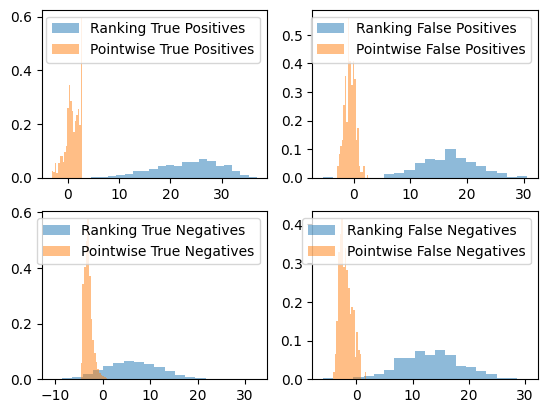

In [31]:
# plot a histogram of the positives and the negatives, in a 2x2 grid
# normalize the histograms to have the same height
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(2, 2)

axs[0, 0].hist(scores['true_positives']['ranking'], bins=20, alpha=0.5, label='Ranking True Positives', density=True)
axs[0, 0].hist(scores['true_positives']['pointwise'], bins=20, alpha=0.5, label='Pointwise True Positives', density=True)
axs[0, 0].legend(loc='upper right')

axs[0, 1].hist(scores['false_positives']['ranking'], bins=20, alpha=0.5, label='Ranking False Positives', density=True)
axs[0, 1].hist(scores['false_positives']['pointwise'], bins=20, alpha=0.5, label='Pointwise False Positives', density=True)
axs[0, 1].legend(loc='upper right')

axs[1, 0].hist(scores['true_negatives']['ranking'], bins=20, alpha=0.5, label='Ranking True Negatives', density=True)
axs[1, 0].hist(scores['true_negatives']['pointwise'], bins=20, alpha=0.5, label='Pointwise True Negatives', density=True)
axs[1, 0].legend(loc='upper right')

axs[1, 1].hist(scores['false_negatives']['ranking'], bins=20, alpha=0.5, label='Ranking False Negatives', density=True)
axs[1, 1].hist(scores['false_negatives']['pointwise'], bins=20, alpha=0.5, label='Pointwise False Negatives', density=True)
axs[1, 1].legend(loc='upper right')

In [25]:
positives = {'ranking': scores['true_positives']['ranking'] + scores['false_positives']['ranking'],
             'pointwise': scores['true_positives']['pointwise'] + scores['false_positives']['pointwise']}
negatives = {'ranking': scores['true_negatives']['ranking'] + scores['false_negatives']['ranking'],
             'pointwise': scores['true_negatives']['pointwise'] + scores['false_negatives']['pointwise']}

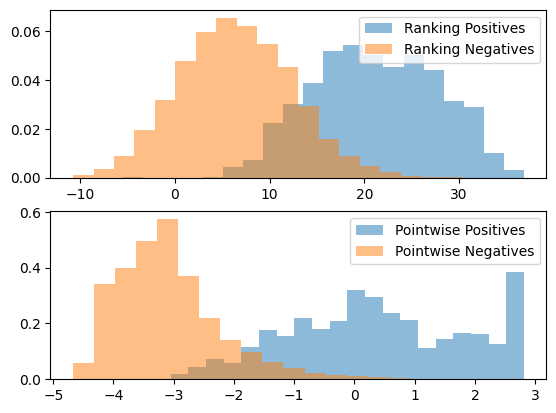

In [36]:
# plot a 2x1 grid of histograms, one for the pointwise and one for the ranking
fig, axs = plt.subplots(2, 1)

axs[0].hist(positives['ranking'], bins=20, alpha=0.5, label='Ranking Positives', density=True)
axs[0].hist(negatives['ranking'], bins=20, alpha=0.5, label='Ranking Negatives', density=True)
axs[0].legend(loc='upper right')

axs[1].hist(positives['pointwise'], bins=20, alpha=0.5, label='Pointwise Positives', density=True)
axs[1].hist(negatives['pointwise'], bins=20, alpha=0.5, label='Pointwise Negatives', density=True)
axs[1].legend(loc='upper right')